In [14]:
import matplotlib.pyplot as plt
import numpy as np

import pylab as pp
import matplotlib as mp
import scipy.integrate as integrate
import scipy.optimize as optimize
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatter

In [4]:
# cost of intervention vs freq infection
m = 1
z_v = 1
f = 0.02

ds = []
b_sweep = np.arange(100) * 0.01
for b in b_sweep:
    d = f*m*(1-z_v*b)
    ds.append(d)

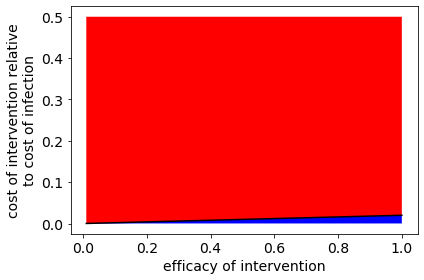

In [8]:
#Figure 1
plt.figure()
plt.plot(1-b_sweep, ds,c="black")
plt.fill_between(1-b_sweep, ds, (0.5), facecolor="red")
plt.fill_between(1-b_sweep, ds, np.min(ds), facecolor="blue")
plt.xlabel("efficacy of intervention", fontsize=14)
plt.ylabel("cost of intervention relative\nto cost of infection", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
#plt.savefig("../efficacy_cost_sweep.eps")
plt.show()

In [1]:
residuals=[]
weights = []
class Parameterize_ODE():
    def __init__(self, S0, E0, I0, R0):
        self.S0 = S0
        self.E0 = E0
        self.I0 = I0
        self.R0 = R0
        
    def odes(self, t, y, p):
        Sv = y[0] #Susceptible vaccinated
        Su = y[1] #Susceptible unvaccinated
        Ev = y[2] #Exposed vaccinated
        Eu = y[3] #Exposed unvaccinated
        Iv = y[4] #Infectious vaccinated
        Iu = y[5] #Infectious unvaccinated
        Rv = y[6] #Recovered vaccinated
        Ru = y[7] #Recovered unvaccinated
        v_cum = y[8] #Cumulative cases among vaccinated
        u_cum = y[9] #Cumulative cases among unvaccinated
        deaths = y[10]
        
        A = p[0]
        R = p[1]
        C = p[2]
        D = p[3]*365/12 #scaled months -> days
        B = C/R #days; contact period
        bvac = 1.0 - p[4]
        c = 1.0 - p[5]
        sigma = p[6]
        mu = p[7]
        lam = p[8]
        f = p[9]
        ni = p[10]


        dSv = -1/B*bvac*Sv*(Iu + Iv*c) + 1/D*Rv - Sv*mu + lam*f + 1/C*Iv*ni
        dSu = -1/B*Su*(Iu + Iv*c) + 1/D*Ru - Su*mu + lam*(1-f) + 1/C*Iu*ni
        
        dEv = 1/B*bvac*Sv*(Iu + Iv*c) - 1/A*Ev - Ev*mu
        dEu = 1/B*Su*(Iu + Iv*c) - 1/A*Eu - Eu*mu
        
        dIv = 1/A*Ev - 1/C*Iv - sigma*Iv - Iv*mu
        dIu = 1/A*Eu - 1/C*Iu - sigma*Iu - Iu*mu
        
        dv_cum = 1/A*Ev
        du_cum = 1/A*Eu
        dDeaths = sigma*Iv + sigma*Iu
        
        dRv = 1/C*Iv*(1-ni) - 1/D*Rv - Rv*mu
        dRu = 1/C*Iu*(1-ni) - 1/D*Ru - Ru*mu
        
        return [dSv, dSu, dEv, dEu, dIv, dIu, dRv, dRu, dv_cum, du_cum, dDeaths]
    
           
    def model(self, t, p):
        #y = [Sv, Su, Ev, Eu, Iv, Iu, R]
        S0 = self.S0
        E0 = self.E0
        I0 = self.I0
        R0 = self.R0
        f = p[9]
        y0 = [S0*f, S0*(1-f), E0*f, E0*(1-f), I0*f, I0*(1-f), R0*f, R0*(1-f), 0, 0, 0]
        r = integrate.solve_ivp(lambda t, y: self.odes(t, y, p), (t[0], t[-1]), y0, t_eval = t)#, method = 'LSODA', min_step = 0.01)
        y = np.array(r.y)
        return y 

In [2]:
#Initial conditions
#I0 = 1./1000000.
I0 = 1.0/500. #initial infected population (fractional)
E0 = I0*3./10. #initial exposed population (fractional)
R0 = 0.08 #Initial recovered population (fractional)
S0 = 1.0 - I0 - E0 - R0 #Initial susceptible population (fractional)

#Disease parameters
A = 3. #days; latent period
C = 10. #days; infectious period
D = 36. #months; duration of immunity (range 3 mo - 2 yrs)
sigma = 0.0068/C #0.003/C #disease death rate (infection fatality rate / infection duration)
ni = 0. #Fraction of infections that do not result in immunity

#Contact parameters
R = 5.7 #Intrinsic reproductive number
B = C/R #days; contact period

#Vaccine parameters
f = 0.95   #fraction vaccinated
bvac = 0.50 # 1 - Relative rate of infection | vaccinated (fractional)
c = 0.50 # 1 - Relative rate of transmission | infected vaccinated (fractional)

#Population dynamics parameters
mu = 0.01/365 #birth rate
lam = 0.01/365 #death rate


po = Parameterize_ODE(S0, E0, I0, R0)

params_optim = [A, R, C, D, bvac, c, sigma, mu, lam, f, ni] 

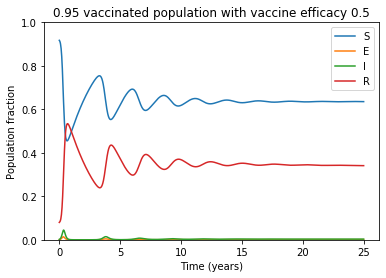

In [7]:
xt = np.linspace(0, 365*25., 1000)
plt.plot(xt/365., po.model(xt, params_optim)[0,:]+po.model(xt, params_optim)[1,:])
plt.plot(xt/365., po.model(xt, params_optim)[2,:]+po.model(xt, params_optim)[3,:])
plt.plot(xt/365., po.model(xt, params_optim)[4,:]+po.model(xt, params_optim)[5,:])
plt.plot(xt/365., po.model(xt, params_optim)[6,:]+po.model(xt, params_optim)[7,:])
plt.ylim([0,1])
plt.xlabel("Time (years)")
plt.ylabel("Population fraction")
plt.title(str(f)+" vaccinated population with vaccine efficacy "+str(bvac))
plt.legend(["S","E","I","R"])
plt.show()

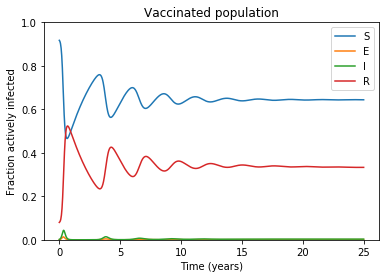

In [5]:
plt.plot(xt/365., po.model(xt, params_optim)[0,:]/f)
plt.plot(xt/365., po.model(xt, params_optim)[2,:]/f)
plt.plot(xt/365., po.model(xt, params_optim)[4,:]/f)
plt.plot(xt/365., po.model(xt, params_optim)[6,:]/f)
plt.ylim([0,1])
plt.xlabel("Time (years)")
plt.ylabel("Fraction actively infected")
plt.title("Vaccinated population")
plt.legend(["S","E","I","R"])
plt.show()

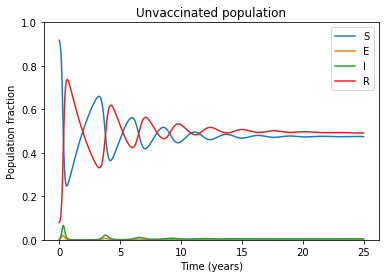

In [6]:
plt.plot(xt/365., po.model(xt, params_optim)[1,:]/(1-f))
plt.plot(xt/365., po.model(xt, params_optim)[3,:]/(1-f))
plt.plot(xt/365., po.model(xt, params_optim)[5,:]/(1-f))
plt.plot(xt/365., po.model(xt, params_optim)[7,:]/(1-f))
plt.ylim([0,1])
plt.xlabel("Time (years)")
plt.ylabel("Population fraction")
plt.title("Unvaccinated population")
plt.legend(["S","E","I","R"])
plt.show()

In [8]:
year24 = po.model(xt, params_optim)[8,int(24/25*1000)]/f
year25 = po.model(xt, params_optim)[8,-1]/f
yearly = round(year25 - year24,2) #yearly infections among vaccinated population
print(yearly)

0.11


In [18]:
def compliancesensitivity(p, xt, vaxonly = False, ymax = 0, color = 'k'):
    compliancerange = np.linspace(0.01, 1, 100)
    yearlys = []
    
    for f in compliancerange:
        #run model
        p[9] = f
        po = Parameterize_ODE(S0, E0, I0, R0)
        model_results = po.model(xt, p)
        
        #outcome metric
        population = 330
        
        if vaxonly == False:
            allyear24 = model_results[8,int(24/25*1000)] + model_results[9,int(24/25*1000)]
            allyear25 = model_results[8,-1] + model_results[9,-1]
            ayearly = (allyear25 - allyear24)*population
            yearlys.append(ayearly)
            
        else: 
            vyear24 = model_results[8,int(24/25*1000)]/p[9]
            vyear25 = model_results[8,-1]/p[9]
            vyearly = (vyear25 - vyear24)
            yearlys.append(vyearly)
        
    
    pp.xlabel("Compliant population (%)")
    if vaxonly == False:
        pp.plot(compliancerange*100, np.array(yearlys), color = color)
        pp.ylabel("Yearly US cases (millions)")
    else:
        pp.plot(compliancerange*100, np.array(yearlys)*100, color = color)
        pp.ylabel("Yearly likelihood of infection for compliant individuals (%)")
    if ymax > 0:
        pp.ylim(top = ymax)
        pp.ylim(bottom=0)
    bottom, top = pp.ylim()
    return(top)

def nscompliancesensitivity(p, xt, vaxonly = False, ymax = 0):
    compliancerange = np.linspace(0.01, 1, 100)
    yearlys = []
    
    for f in compliancerange:
        #run model
        p[9] = f
        po = Parameterize_ODE(S0, E0, I0, R0)
        model_results = po.model(xt, p)
        
        #outcome metric
        population = 330
        
        if vaxonly == False:
            allyear24 = model_results[8,int(24/25*1000)] + model_results[9,int(24/25*1000)]
            allyear25 = model_results[8,-1] + model_results[9,-1]
            ayearly = (allyear25 - allyear24)*population
            yearlys.append(ayearly)
            
        else: 
            vyear24 = model_results[8,int(24/25*1000)]/p[9]
            vyear25 = model_results[8,-1]/p[9]
            vyearly = (vyear25 - vyear24)
            yearlys.append(vyearly)
        
    pp.plot(compliancerange*100, np.array(yearlys)*100)
    pp.xlabel("Compliant population (%)")
    if vaxonly == False:
        pp.ylabel("Yearly US cases (millions)")
    else:
        pp.ylabel("Yearly likelihood of infection for compliant individuals (%)")
    if ymax > 0:
        pp.ylim(top = ymax)
        pp.ylim(bottom=0)
    bottom, top = pp.ylim()
    return(top)
    
def complianceslope(p, xt):
    compliancerange = np.linspace(0.01, 1, 25)
    yearlys = []
    
    for f in compliancerange:
        #run model
        p[9] = f
        po = Parameterize_ODE(S0, E0, I0, R0)
        model_results = po.model(xt, p)
        
        #outcome metric
        population = 330
        

        allyear24 = model_results[8,int(24/25*1000)] + model_results[9,int(24/25*1000)]
        allyear25 = model_results[8,-1] + model_results[9,-1]
        ayearly = (allyear25 - allyear24)*population
        yearlys.append(ayearly)
                
    dydxs = []
    yearlys.reverse()
    list(compliancerange).reverse()
    for index in range(len(yearlys)-1):
        dy = yearlys[index+1] - yearlys[index]
        #dx = compliancerange[index+1] - compliancerange[index]
        dydxs.append(dy/4)
    pp.plot(np.array(compliancerange[1:])*100., dydxs)
    pp.xlabel("Noncompliant population (%)")
    pp.ylabel("Marginal cost of noncompliance (millions of cases)")
    pp.ylim([0,5])
    
def multisensitivity(paramx, minx, maxx, paramy, miny, maxy, p, norm = ""):
    # Create a linearly spaced vector to run the optimized model at
    xt = np.linspace(0, 365*1., 1000) #3 years
    
    points = 10
    prangey = np.linspace(miny, maxy, num=points)
    prangex = np.linspace(minx, maxx, num=points)

    allarray = np.zeros((points,points))
    i2 = 0
    for valx in prangex:
        p[paramx] = valx
        print(i2)
        i1 = 0
        for valy in prangey:
            p[paramy] = valy
            p[5] = p[4]  #fix transmission reduction to protection for vaccine
            
            #run model
            po = Parameterize_ODE(S0, E0, I0, R0)
            model_results = po.model(xt, p)
            
            #outcome metric
            population = 330
            allcases = (model_results[8,-1] + model_results[9,-1])*population
            
            allarray[i1,i2] = allcases
            i1+=1
        i2 += 1
           
    cmap1 = mp.cm.Reds
    params_list = ["Latency period (days)", "Intrinsic R0 (individuals)", "Infectious period (days)", "Duration of Natural Immunity (months)", "Intervention efficacy", "Vaccine efficacy (fractional transmission)", "Infection Fatality Rate", "Natural Death Rate (daily)", "Natural Birth Rate (daily)", "Fraction Compliant"]

    pp.figure()
    print(allarray.min(), allarray.max())
    if norm == "log":
        pp.pcolor(prangex, prangey, allarray, cmap = cmap1, norm=LogNorm(vmin=allarray.min(), vmax=allarray.max()))
        formatter = LogFormatter(10, labelOnlyBase=False) 
        cb = pp.colorbar(cmap = cmap1, label="Total US Infections (millions)", ticks=[1,10], format=formatter)
    else: 
        pp.pcolor(prangex, prangey, allarray, cmap = cmap1)
        pp.colorbar(cmap = cmap1, label="Total US Infections (millions)")
    pp.ylabel(params_list[paramy])
    pp.xlabel(params_list[paramx])
    pp.tight_layout()
    pp.show() 

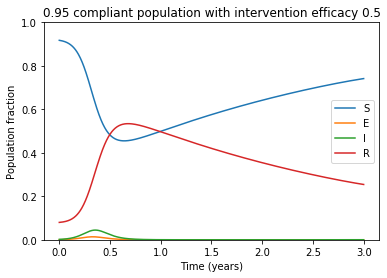

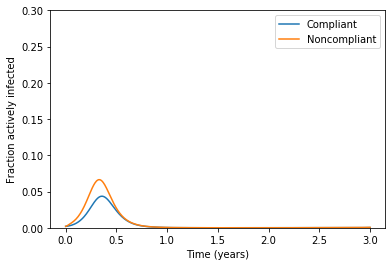

/Users/dve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


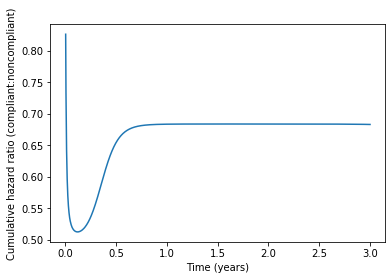

In [29]:
#Figure 2a
xt2 = np.linspace(0, 365*3., 1000)
p2 = params_optim.copy()
p2[4] = 0.5
p2[5] = 0.5
p2[9] = 0.95

results = po.model(xt2, p2)
pp.plot(xt2/365., results[0,:]+results[1,:])
pp.plot(xt2/365., results[2,:]+results[3,:])
pp.plot(xt2/365., results[4,:]+results[5,:])
pp.plot(xt2/365., results[6,:]+results[7,:])
pp.ylim([0,1])
pp.xlabel("Time (years)")
pp.ylabel("Population fraction")
pp.title(str(p2[9])+" compliant population with intervention efficacy "+str(p2[4]))
pp.legend(["S","E","I","R"])
pp.show()

pp.plot(xt2/365., results[4,:]/p2[9])
pp.plot(xt2/365., results[5,:]/(1-p2[9]))
pp.xlabel("Time (years)")
pp.ylim([0,0.3])
pp.ylabel("Fraction actively infected")
pp.legend(["Compliant","Noncompliant"])
pp.show()

pp.plot(xt2/365., (results[8,:]/f)/(results[9,:]/(1-f)))
pp.xlabel("Time (years)")
pp.ylabel("Cumulative hazard ratio (compliant:noncompliant)")
pp.show()

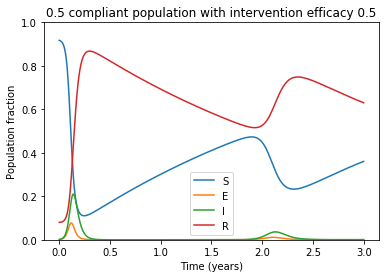

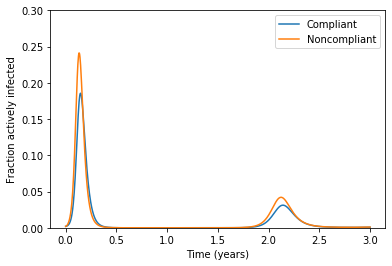

/Users/dve/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


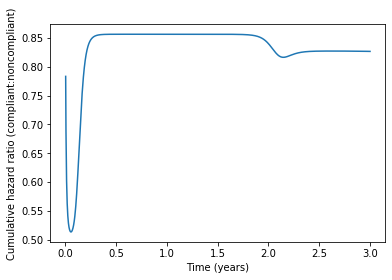

In [12]:
#Figure 2b
xt2 = np.linspace(0, 365*3., 1000)
p2 = params_optim.copy()
p2[4] = 0.5
p2[5] = 0.5
p2[9] = 0.5
results = po.model(xt2, p2)
plt.plot(xt2/365., results[0,:]+results[1,:])
plt.plot(xt2/365., results[2,:]+results[3,:])
plt.plot(xt2/365., results[4,:]+results[5,:])
plt.plot(xt2/365., results[6,:]+results[7,:])
plt.ylim([0,1])
plt.xlabel("Time (years)")
plt.ylabel("Population fraction")
plt.title(str(p2[9])+" compliant population with intervention efficacy "+str(p2[4]))
plt.legend(["S","E","I","R"])
plt.show()

plt.plot(xt2/365., results[4,:]/p2[9])
plt.plot(xt2/365., results[5,:]/(1-p2[9]))
plt.xlabel("Time (years)")
plt.ylim([0,0.3])
plt.ylabel("Fraction actively infected")
plt.legend(["Compliant","Noncompliant"])
plt.show()

plt.plot(xt2/365., (results[8,:]/p2[9])/(results[9,:]/(1-p2[9])))
plt.xlabel("Time (years)")
plt.ylabel("Cumulative hazard ratio (compliant:noncompliant)")
plt.show()

0
1
2
3
4
5
6
7
8
9
0.1979123592139873 281.9775703214379


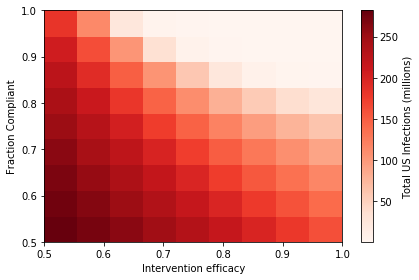

0
1
2
3
4
5
6
7
8
9
0.1979123592139873 48.80353053581985


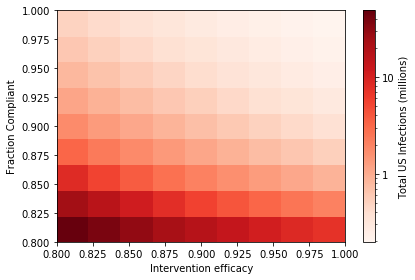

90,90 0.5682146696479804
95,95 0.2560517571874317


In [20]:
#Fig 3
xt2 = np.linspace(0, 365, 1000)
multisensitivity(4, 0.5, 1, 9, 0.5, 1, params_optim)
multisensitivity(4, 0.8, 1, 9, 0.8, 1, params_optim, norm = "log")

p3 = params_optim.copy()
p3[9] = 0.9
p3[4] = 0.9
p3[5] = 0.9
model_results = po.model(xt2, p3)
print("90,90",(model_results[8,-1] + model_results[9,-1])*330)
p3[9] = 0.95
p3[4] = 0.95
p3[5] = 0.95
model_results = po.model(xt2, p3)
print("95,95",(model_results[8,-1] + model_results[9,-1])*330)

[3.0, 5.7, 10.0, 36.0, 1.0, 1.0, 0.0006799999999999999, 2.7397260273972603e-05, 2.7397260273972603e-05, 1.0, 0.0]


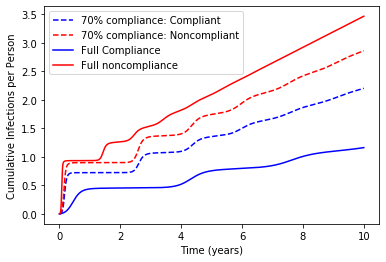

In [21]:
#Figure 4a
xt = np.linspace(0, 365*10., 1000)
p2a = params_optim.copy()
print(p2a)
p2a[4] = 0.5
p2a[5] = 0.5
p2a[9] = 0.7
plt.plot(xt/365., po.model(xt, p2a)[8,:]/(p2a[9]), color = 'b', linestyle = 'dashed')
plt.plot(xt/365., po.model(xt, p2a)[9,:]/(1-p2a[9]), color = 'r', linestyle = 'dashed')
#print(po.model(xt, params_optim)[8,-1]/(f), po.model(xt, p2a)[9,-1]/(1-f))
p2a[9] = 1.
plt.plot(xt/365., po.model(xt, p2a)[8,:], color = 'b')
p2a[9] = 0.
plt.plot(xt/365., po.model(xt, p2a)[9,:], color = 'r')
plt.xlabel("Time (years)")
plt.ylabel("Cumulative Infections per Person")
plt.legend(["70% compliance: Compliant", "70% compliance: Noncompliant", "Full Compliance", "Full noncompliance"])
plt.show()

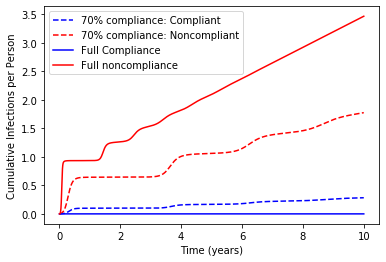

In [22]:
#Figure 4b,covidiots
p2b = params_optim.copy()
p2b[4] = 0.9
p2b[5] = 0.9
p2b[9] = 0.7
plt.plot(xt/365., po.model(xt, p2b)[8,:]/(p2b[9]), color = 'b', linestyle = 'dashed')
plt.plot(xt/365., po.model(xt, p2b)[9,:]/(1-p2b[9]), color = 'r', linestyle = 'dashed')
#print(po.model(xt, params_optim)[8,-1]/(f), po.model(xt, params_optim)[9,-1]/(1-f))
p2b[9] = 1.
plt.plot(xt/365., po.model(xt, p2b)[8,:], color = 'b')
p2b[9] = 0.
plt.plot(xt/365., po.model(xt, p2b)[9,:], color = 'r')
plt.xlabel("Time (years)")
plt.ylabel("Cumulative Infections per Person")
plt.legend(["70% compliance: Compliant", "70% compliance: Noncompliant", "Full Compliance", "Full noncompliance"])
plt.show()

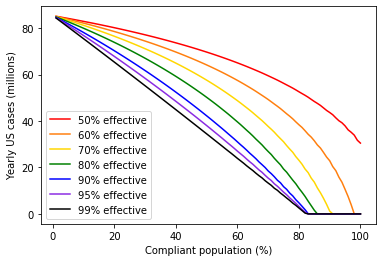

In [23]:
#Covidiots Figure 5
xt = np.linspace(0, 365*25., 1000)
pS3 = params_optim.copy()
pS3[4] = 0.5
pS3[5] = 0.5
compliancesensitivity(pS3, xt, color = 'r')
pS3[4] = 0.6
pS3[5] = 0.6
compliancesensitivity(pS3, xt, color = 'tab:orange')
pS3[4] = 0.7
pS3[5] = 0.7
compliancesensitivity(pS3, xt, color = 'gold')
pS3[4] = 0.8
pS3[5] = 0.8
compliancesensitivity(pS3, xt, color = 'g')
pS3[4] = 0.9
pS3[5] = 0.9
compliancesensitivity(pS3, xt, color = 'b')
pS3[4] = 0.95
pS3[5] = 0.95
compliancesensitivity(pS3, xt, color = 'blueviolet')
pS3[4] = 0.99
pS3[5] = 0.99
compliancesensitivity(pS3, xt, color = 'k')
plt.legend(["50% effective", "60% effective", "70% effective", "80% effective", "90% effective", "95% effective", "99% effective"])
plt.show()

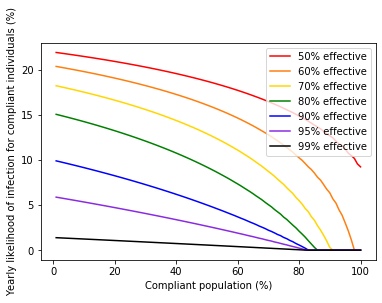

In [24]:
#Covidiots Figure 6
xt = np.linspace(0, 365*25., 1000)
p4 = params_optim.copy()
p4[4] = 0.5
p4[5] = 0.5
compliancesensitivity(p4, xt, True, color = 'r')
p4[4] = 0.6
p4[5] = 0.6
compliancesensitivity(p4, xt, True, color = 'tab:orange')
p4[4] = 0.7
p4[5] = 0.7
compliancesensitivity(p4, xt, True, color = 'gold')
p4[4] = 0.8
p4[5] = 0.8
compliancesensitivity(p4, xt, True, color = 'g')
p4[4] = 0.9
p4[5] = 0.9
compliancesensitivity(p4, xt, True, color = 'b')
p4[4] = 0.95
p4[5] = 0.95
compliancesensitivity(p4, xt, True, color = 'blueviolet')
p4[4] = 0.99
p4[5] = 0.99
compliancesensitivity(p4, xt, True, color = 'k')
plt.legend(["50% effective", "60% effective", "70% effective", "80% effective", "90% effective", "95% effective", "99% effective"])
plt.show()

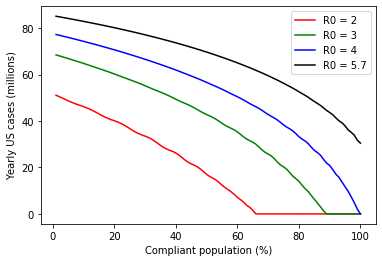

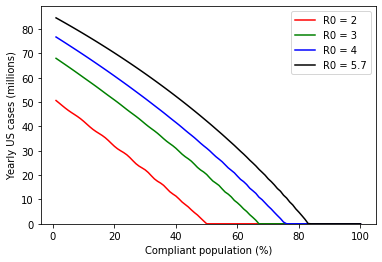

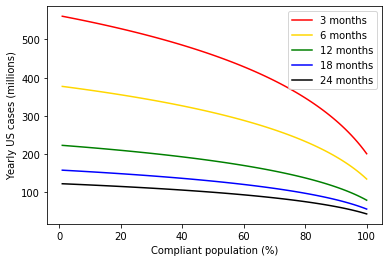

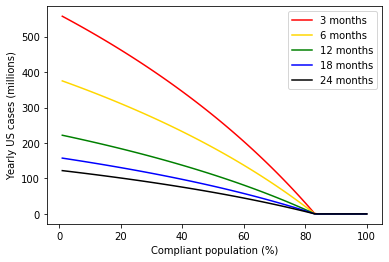

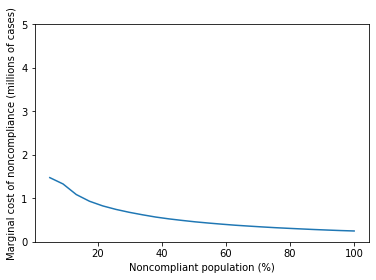

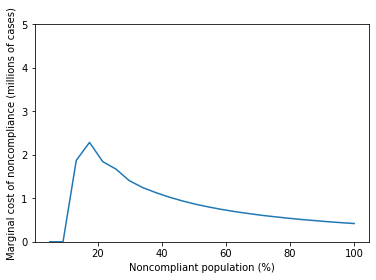

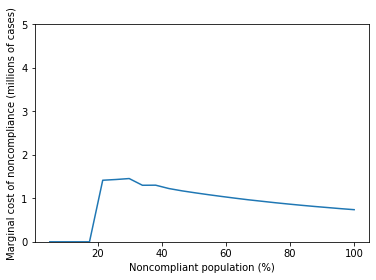

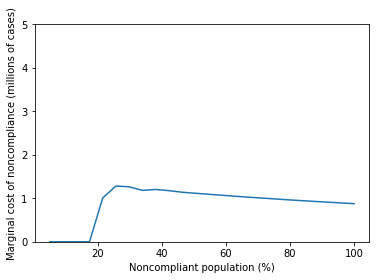

In [25]:
#Covidiots Figure S2a
xt = np.linspace(0, 365*25., 1000)
pS1 = params_optim.copy()
pS1[4] = 0.5
pS1[5] = 0.5
pS1[1] = 2
compliancesensitivity(pS1, xt, color = 'r')
pS1[1] = 3
compliancesensitivity(pS1, xt, color = 'g')
pS1[1] = 4
compliancesensitivity(pS1, xt, color = 'b')
pS1[1] = 5.7
ymax1a = compliancesensitivity(pS1, xt, color = 'k')
plt.legend(["R0 = 2", "R0 = 3", "R0 = 4", "R0 = 5.7"])
plt.show()

#Covidiots Figure S2b
pS1 = params_optim.copy()
pS1[4] = 0.9
pS1[5] = 0.9
pS1[1] = 2
compliancesensitivity(pS1, xt, color = 'r')
pS1[1] = 3
compliancesensitivity(pS1, xt, color = 'g')
pS1[1] = 4
compliancesensitivity(pS1, xt, color = 'b')
pS1[1] = 5.7
compliancesensitivity(pS1, xt, ymax = ymax1a, color = 'k')
plt.legend(["R0 = 2", "R0 = 3", "R0 = 4", "R0 = 5.7"])
plt.show()

#Covidiots Figure S2a
xt = np.linspace(0, 365*25., 1000)
pS2 = params_optim.copy()
pS2[4] = 0.5
pS2[5] = 0.5
pS2[3] = 3
compliancesensitivity(pS2, xt, color = 'r')
pS2[3] = 6
compliancesensitivity(pS2, xt, color = 'gold')
pS2[3] = 12
compliancesensitivity(pS2, xt, color = 'g')
pS2[3] = 18
compliancesensitivity(pS2, xt, color = 'b')
pS2[3] = 24
ymax2a = compliancesensitivity(pS2, xt, color = 'k')
plt.legend(["3 months","6 months", "12 months", "18 months", "24 months"])
plt.show()

#Covidiots Figure S2b
pS2 = params_optim.copy()
pS2[4] = 0.9
pS2[5] = 0.9
pS2[3] = 3
compliancesensitivity(pS2, xt, color = 'r')
pS2[3] = 6
compliancesensitivity(pS2, xt, color = 'gold')
pS2[3] = 12
compliancesensitivity(pS2, xt, color = 'g')
pS2[3] = 18
compliancesensitivity(pS2, xt, color = 'b')
pS2[3] = 24
compliancesensitivity(pS2, xt, color = 'k')#, ymax = 450)
plt.legend(["3 months","6 months", "12 months", "18 months", "24 months"])
plt.show()

#Covidiots Figure S3

xt = np.linspace(0, 365*25., 1000)
pS4 = params_optim.copy()
pS4[4] = 0.5
pS4[5] = 0.5
complianceslope(pS4, xt)
plt.show()
pS4[4] = 0.7
pS4[5] = 0.7
complianceslope(pS4, xt)
plt.show()
pS4[4] = 0.9
pS4[5] = 0.9
complianceslope(pS4, xt)
plt.show()
pS4[4] = 0.95
pS4[5] = 0.95
complianceslope(pS4, xt)
plt.show()